# Sentiment Classification with Deeplearning

### 1.Import Libraries/Dataset.
> a.Import the required libraries andthe dataset (use Google Drive if required).

>b.Check the GPU available (recommended-use free GPU provided by Google Colab).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import pandas as pd
import seaborn as sns

path = "/content/drive/MyDrive/IMDB Dataset.csv"
df = pd.read_csv(path)

### 2.Data Visualization.
> a.Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text.

> b.Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets belonging to a particular sentiment. (recommended -matplotlib/seaborn libraries)

>c.Any other visualizations that seem appropriate for this problem are encouraged but not necessary, for the points.

>d.Print the shapes of train and test data.

In [ ]:
df.groupby('sentiment', as_index=False).head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


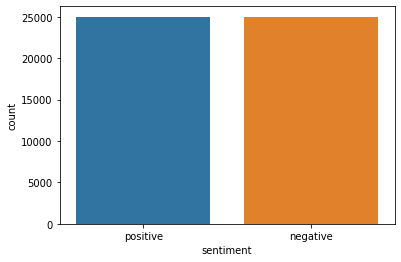

In [ ]:
sns.countplot(df["sentiment"])

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df['sentiment'] = pd.Categorical(df['sentiment'])
df['sentiment'] = df.sentiment.cat.codes

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [ ]:
train.shape, test.shape

((40000, 2), (10000, 2))

### 3.Data Pre-processing
> a.Need for this Step-Since the models we use cannot accept string inputs or cannot be of the string format. We have to come up with a way of handling this step. The discussion of different ways of handling this step is out of the scope of this assignment.

> b.Please use this pre-trained embedding layerfrom TensorFlow hub for this assignment. This link also has a code snippet on how to convert a sentence to a vector. Refer to that for further clarity on this subject.

> c.Bring the train and test data in the required format.

In [ ]:
x_train = train['review'].to_numpy()
y_train = train['sentiment'].to_numpy()

x_test = test['review'].to_numpy()
y_test = test['sentiment'].to_numpy()

In [ ]:
 import tensorflow_hub as hub
embedding = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1")

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

### 4.Model Building
> a.Sequential Model layers-Use AT LEAST 3 hiddenlayers with appropriate input for each. Choose the best number for hidden units and give reasons.

> b.Add L2 regularization to all the layers.

> c.Add one layer of dropout at the appropriate position and give reasons.

> d.Choose the appropriate activation function for all the layers.

> e.Print the model summary.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(), name="Input", dtype=tf.string))
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 124,647,361
Trainable params: 124,647,361
Non-trainable params: 0
_________________________________________________________________


Reason for choosing Hidden units:

There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:

1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.<br>
2. <b>The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.</b><br>
3. The number of hidden neurons should be less than twice the size of the input layer.

Using these 3 formulas.<br> 
Getting values ~ 32 and 16 for the 2 hidden layers.

Reason for putting dropout just after the pre-trained vector.

<b>Usually, dropout is placed on the fully connected layers only because they are the one with the greater number of parameters and thus they're likely to excessively co-adapting themselves causing overfitting</b>

Choice of Activation functions:

<b> We have used relu, in all the hidden layers because rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better.

In the output layer, we want binary output (0 or 1) so we have used sigmoid.

### 5.Model Compilation

> a.Compile the model with the appropriate loss function.

> b.Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

>c.Use accuracy as metric.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

We are choosing Adam Optimizer.

Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. <b> This algorithm is used to accelerate the gradient descent algorithm by taking into consideration the 'exponentially weighted average' of the gradients. Using averages makes the algorithm converge towards the minima in a faster pace </b>

<br>

<b>Adam is and adaptive optimizer, and it learns the learning rates itself, on a per-parameter basis. So we are not specifying learning rate

### 6.Model Training

> a.Train the model for an appropriate number of epochs. Print the train and validation accuracyand loss for each epoch. Use the appropriate batch size.

> b.Plot the loss and accuracy history graphsfor both train and validation set. Print the total time taken for training.

In [ ]:
import time

t= time.time()

history = model.fit(train_ds.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=test_ds.batch(512),
                    verbose=1)

t = time.time() -t

Epoch 1/10
79/79 [==============================] - 11s 102ms/step - loss: 6.3766 - accuracy: 0.6091 - val_loss: 2.9729 - val_accuracy: 0.8226
Epoch 2/10
79/79 [==============================] - 8s 97ms/step - loss: 2.4427 - accuracy: 0.7715 - val_loss: 1.3073 - val_accuracy: 0.8558
Epoch 3/10
79/79 [==============================] - 8s 97ms/step - loss: 1.1368 - accuracy: 0.8438 - val_loss: 0.7530 - val_accuracy: 0.8718
Epoch 4/10
79/79 [==============================] - 8s 96ms/step - loss: 0.6873 - accuracy: 0.8781 - val_loss: 0.5494 - val_accuracy: 0.8825
Epoch 5/10
79/79 [==============================] - 8s 96ms/step - loss: 0.5052 - accuracy: 0.9010 - val_loss: 0.4629 - val_accuracy: 0.8862
Epoch 6/10
79/79 [==============================] - 8s 96ms/step - loss: 0.4212 - accuracy: 0.9142 - val_loss: 0.4210 - val_accuracy: 0.8881
Epoch 7/10
79/79 [==============================] - 8s 96ms/step - loss: 0.3652 - accuracy: 0.9303 - val_loss: 0.3983 - val_accuracy: 0.8921
Epoch 8/10


In [ ]:
print('Time taken to train: {}'.format(t))


Time taken to train: 80.07733941078186


In [ ]:
# Plot the loss and accuracy history graphs for both train and validation set. Print the total
# time taken for training.

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

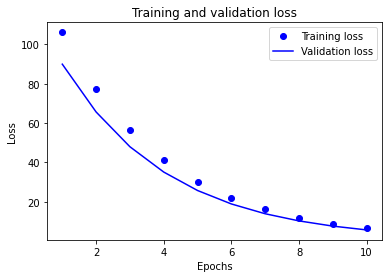

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

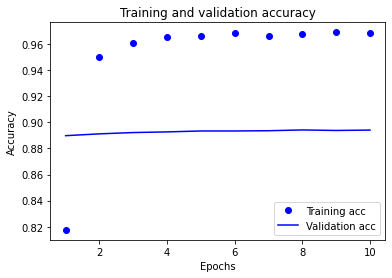

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7.Model Evaluation
> a.Print the final train and validation loss and accuracy.Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

>b.Print the two most incorrectly classified texts foreach class in the test dataset.

In [ ]:
results = model.evaluate(test_ds.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

20/20 - 0s - loss: 0.3706 - accuracy: 0.8943
loss: 0.371
accuracy: 0.894


In [ ]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
y_pred_prob = model.predict(x_test)

In [ ]:
# Confusion Matrix

confusion = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
confusion

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[4534,  523],
       [ 534, 4409]], dtype=int32)>

In [ ]:
from sklearn.metrics import classification_report
import time
import numpy as np
start_time = time.time()
test_predictions = (model.predict(x_test) > 0.5).astype("int32")
# Comparing the predictions to actual forest cover types for the test rows
# test is the data right after splitting into train, test and val (shuffle was false in dataset so the order will match)
print(classification_report(y_test,test_predictions))
print("Time taken to predict the model " + str(time.time() - start_time))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      5057
           1       0.89      0.89      0.89      4943

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Time taken to predict the model 0.931915283203125


#### Compute most errorenous predictions

In [ ]:
res = []
for i,j,k  in zip(x_test, y_test, y_pred_prob):
    res.append([i, j-k])
    

In [ ]:
def takeSecond(elem):
    return elem[1]
res.sort(key=takeSecond)

In [ ]:
# Most errorenous positive predictions
res[:2]

[["this is a great movie. I love the series on tv and so I loved the movie. One of the best things in the movie is that Helga finally admits her deepest darkest secret to Arnold!!! that was great. i loved it it was pretty funny too. It's a great movie! Doy!!!",
  array([-0.99687517], dtype=float32)],
 ["Jack London's life was certainly colorful enough for a dozen films about different aspects of him. Sad to say though that what his life was used for in film was some wartime propaganda that put the best face on some of the least attractive parts of his character.<br /><br />Jack London who barely saw the age of 40 when he died wrote some of the best stories around. He wrote on what he knew, but he also wrote as does everyone else bringing the baggage of his own life experience with him. Some of that experience in another day and time would have been condemned as racism. But this was World War II and London was a big believer in the 'yellow peril' as it was called back in the day.<br /><

In [ ]:
# Most errorenous negative predictions
res[-2:]

[["This is simply the funniest movie I've seen in a long time. The bad acting, bad script, bad scenery, bad costumes, bad camera work and bad special effects are so stupid that you find yourself reeling with laughter.<br /><br />So it's not gonna win an Oscar but if you've got beer and friends round then you can't go wrong.",
  array([0.975356], dtype=float32)],
 ['This movie has to be my favorite of all time. Its not supposed to have a plot, because its makers wanted people (Charlie Sheen, I think)to believe it was a real snuff film. This was an exercise in visual effects, and doesn\'t cut away when the action happens like every other film does. Movies these days are now all about sound effects, leaving the visuals to be made by computers cause its easier to deal with CGI blood. There still are movie makers who still can\'t get fake blood to look like the real thing. There is no rape scene because that wasn\'t the point of making the film. Have you seen the hills have eyes 2? The rape

### Hyperparameter Tuning
Build two more models by changing the following hyperparameters one at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.

> 1. Network Depth: Change the number of hidden layers and hidden units for each layer

>2. Optimiser: Use a different optimizer with the appropriate LR value. Write a comparison between each model and give reasons for the difference in results.

### Modified Model 1

In [ ]:
import gc
tf.keras.backend.clear_session()
gc.collect()

3738

In [ ]:
# Dropout: Change the position and value of dropout layer

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Input(shape=(), name="Input", dtype=tf.string))
model1.add(hub_layer)
model1.add(tf.keras.layers.Dropout(0.50))
model1.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model1.add(tf.keras.layers.Dropout(0.50))
model1.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model1.add(tf.keras.layers.Dropout(0.50))
model1.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model1.add(tf.keras.layers.Dropout(0.20))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                5

In [ ]:
model1.compile(optimizer='adamax',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])  
              # metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])  

In [ ]:
history = model1.fit(x_train,
                    y_train,
                    epochs=25,
                    batch_size=256,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/25
157/157 [==============================] - 4s 24ms/step - loss: 13.8340 - accuracy: 0.7446 - val_loss: 3.4910 - val_accuracy: 0.8863
Epoch 2/25
157/157 [==============================] - 4s 23ms/step - loss: 2.4984 - accuracy: 0.9740 - val_loss: 1.1310 - val_accuracy: 0.8861
Epoch 3/25
157/157 [==============================] - 4s 23ms/step - loss: 0.8280 - accuracy: 0.9881 - val_loss: 0.6743 - val_accuracy: 0.8861
Epoch 4/25
157/157 [==============================] - 4s 24ms/step - loss: 0.4769 - accuracy: 0.9891 - val_loss: 0.5453 - val_accuracy: 0.8864
Epoch 5/25
157/157 [==============================] - 4s 23ms/step - loss: 0.3660 - accuracy: 0.9896 - val_loss: 0.4966 - val_accuracy: 0.8859
Epoch 6/25
157/157 [==============================] - 4s 23ms/step - loss: 0.3171 - accuracy: 0.9887 - val_loss: 0.4722 - val_accuracy: 0.8861
Epoch 7/25
157/157 [==============================] - 4s 23ms/step - loss: 0.2862 - accuracy: 0.9900 - val_loss: 0.4588 - val_accuracy: 0.886

In [ ]:
results = model.evaluate(x_test, y_test)

print(results)

313/313 [==============================] - 1s 4ms/step - loss: 0.3843 - accuracy: 0.8881
[0.38433611392974854, 0.8881000280380249]


### Modified Model 2

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

3277

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(), name="Input", dtype=tf.string))
model.add(hub_layer)
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 124,653,569
Trainable params: 124,653,569
Non-trainable params: 0
__________________________________________

In [ ]:
model.compile(optimizer='sgd',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])  

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=25,
                    batch_size=512,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/25
79/79 [==============================] - 4s 42ms/step - loss: 14.4420 - accuracy: 0.7290 - val_loss: 11.4588 - val_accuracy: 0.8758
Epoch 2/25
79/79 [==============================] - 3s 40ms/step - loss: 10.5917 - accuracy: 0.9831 - val_loss: 8.4672 - val_accuracy: 0.8843
Epoch 3/25
79/79 [==============================] - 3s 40ms/step - loss: 7.8069 - accuracy: 0.9936 - val_loss: 6.2987 - val_accuracy: 0.8837
Epoch 4/25
79/79 [==============================] - 3s 40ms/step - loss: 5.7818 - accuracy: 0.9941 - val_loss: 4.7244 - val_accuracy: 0.8846
Epoch 5/25
79/79 [==============================] - 3s 40ms/step - loss: 4.3105 - accuracy: 0.9939 - val_loss: 3.5793 - val_accuracy: 0.8855
Epoch 6/25
79/79 [==============================] - 3s 39ms/step - loss: 3.2360 - accuracy: 0.9926 - val_loss: 2.7458 - val_accuracy: 0.8858
Epoch 7/25
79/79 [==============================] - 3s 40ms/step - loss: 2.4535 - accuracy: 0.9925 - val_loss: 2.1379 - val_accuracy: 0.8866
Epoch 8/25

In [ ]:
results = model.evaluate(x_test, y_test)

print(results)

313/313 [==============================] - 1s 4ms/step - loss: 0.4692 - accuracy: 0.8856
[0.46918848156929016, 0.8855999708175659]


Comparision of 3 models

1. Base Model: 

  --->Training set : loss: 0.2919 - accuracy: 0.9493 <br>
  --->Test Set: loss: 0.371 - accuracy: 0.894 

<br><br>
2. Model 1: loss:

  --->Training set : loss: 0.1692 - accuracy: 0.9908 <br>
  --->Test Set: loss: 0.3843 - accuracy: 0.8881

<br><br>
3. Model 2:

  --->Training set : loss: 0.2694 - accuracy: 0.9930 <br>
  --->Test Set: loss: 0.4692 - accuracy: 0.8856


  *Base model is the best among 3 as it has more accuracy on test data compared to other models while other models has more accuracy on training data that shows overfitting.*